In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [4]:
df = pd.read_csv('../data/Airlines.csv', index_col=None)

# Sample 10,000 rows randomly for fast development
df = df.sample(n=10000, random_state=42)
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
442150,442151,OO,6477,SMF,LAX,7,881,85,1
229730,229731,UA,310,DEN,LGA,2,665,223,1
69994,69995,WN,1739,OAK,LAS,7,465,85,1
414293,414294,B6,1085,JFK,CLT,5,990,131,0
171704,171705,AS,129,SEA,FAI,5,1150,235,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 442150 to 390100
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10000 non-null  int64 
 1   Airline      10000 non-null  object
 2   Flight       10000 non-null  int64 
 3   AirportFrom  10000 non-null  object
 4   AirportTo    10000 non-null  object
 5   DayOfWeek    10000 non-null  int64 
 6   Time         10000 non-null  int64 
 7   Length       10000 non-null  int64 
 8   Delay        10000 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 781.2+ KB


In [6]:
df.columns, df.columns.shape

(Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
        'Time', 'Length', 'Delay'],
       dtype='object'),
 (9,))

In [7]:
df.index, df.index.shape

(Index([442150, 229730,  69994, 414293, 171704,  82605, 195559, 433511, 220996,
        495964,
        ...
        301846, 273565,  67709, 125188, 119709, 199484, 224533,  71450, 326676,
        390100],
       dtype='int64', length=10000),
 (10000,))

In [8]:
df.values, df.values.shape

(array([[442151, 'OO', 6477, ..., 881, 85, 1],
        [229731, 'UA', 310, ..., 665, 223, 1],
        [69995, 'WN', 1739, ..., 465, 85, 1],
        ...,
        [71451, 'OO', 6952, ..., 546, 128, 0],
        [326677, 'DL', 2849, ..., 1175, 299, 0],
        [390101, 'OO', 6846, ..., 641, 82, 0]], dtype=object),
 (10000, 9))

## 2. Data Cleaning

In [9]:
df['Delay'] = df['Delay'].map({0: 'Not Delayed', 1: 'Delayed'})

### A. Handle Missing Values

In [10]:
print("Missing values in each column")
df.isnull().sum()

Missing values in each column


id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

### B. Remove Duplicates

In [11]:
print("Number of duplicate rows before")
df.duplicated().sum()

Number of duplicate rows before


0

## 3. Exploratory Data Analysis (EDA)

In [12]:
import os

os.makedirs("../outputs/eda", exist_ok=True)
os.makedirs("../outputs/results", exist_ok=True)
os.makedirs("../outputs/models", exist_ok=True)

In [13]:
numerical_cols = df.select_dtypes(include=['number']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()

print("Numerical Col :: ", numerical_cols)
print("Category col  :: ", categorical_cols)

Numerical Col ::  ['id', 'Flight', 'DayOfWeek', 'Time', 'Length']
Category col  ::  ['Airline', 'AirportFrom', 'AirportTo', 'Delay']


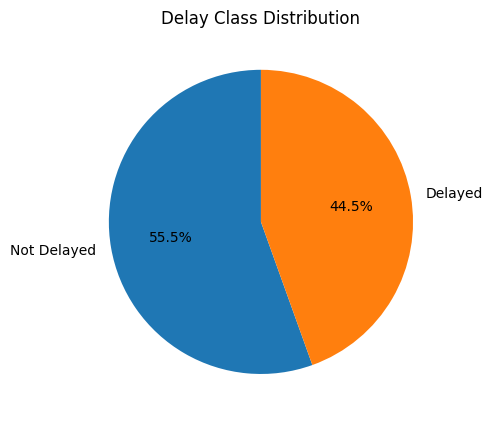

In [14]:
plt.figure(figsize = (5, 5))
df['Delay'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Not Delayed', 'Delayed'])
plt.title('Delay Class Distribution')
plt.ylabel('')
plt.savefig("../outputs/eda/delay_class_distribution.png")
plt.tight_layout()

### A. Univariate Analysis

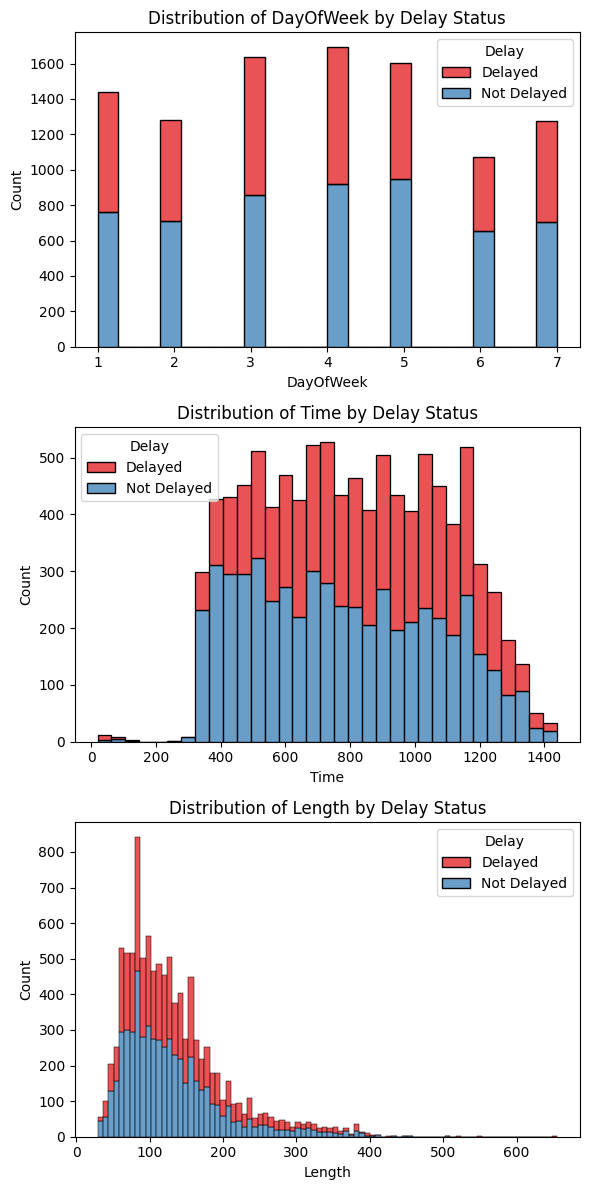

In [15]:
# Numerical Column
numerical_cols = ['DayOfWeek', 'Time', 'Length']

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(6, 12)) 
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='Delay', ax=axes[i], palette='Set1', multiple='stack')
    axes[i].set_title(f'Distribution of {col} by Delay Status')

plt.savefig("../outputs/eda/delay_vs_numerical_col.png")
plt.tight_layout()
plt.show()

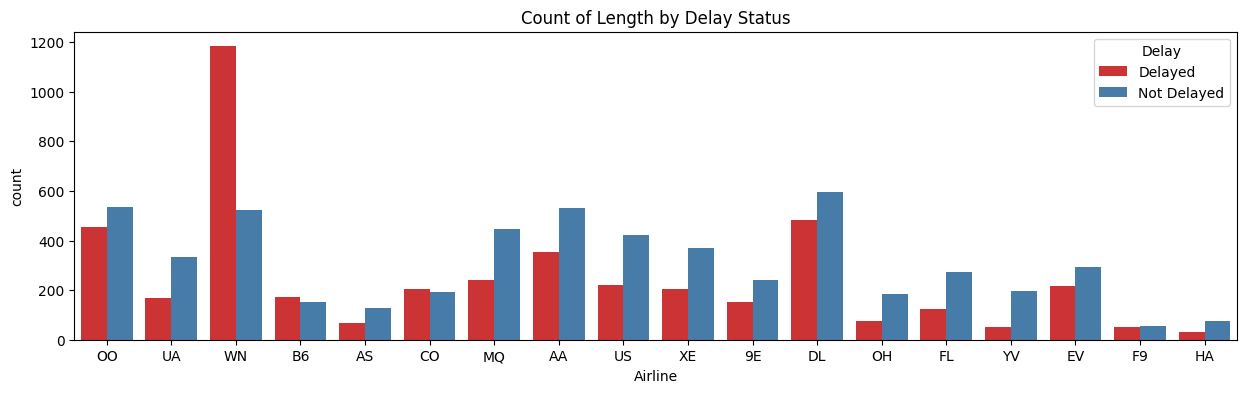

In [16]:
# Categorical Column
plt.figure(figsize=(15, 4))
sns.countplot(data=df, x='Airline', hue='Delay', palette='Set1')
plt.title(f'Count of {col} by Delay Status')
plt.savefig("../outputs/eda/delay_vs_length.png")
plt.show()

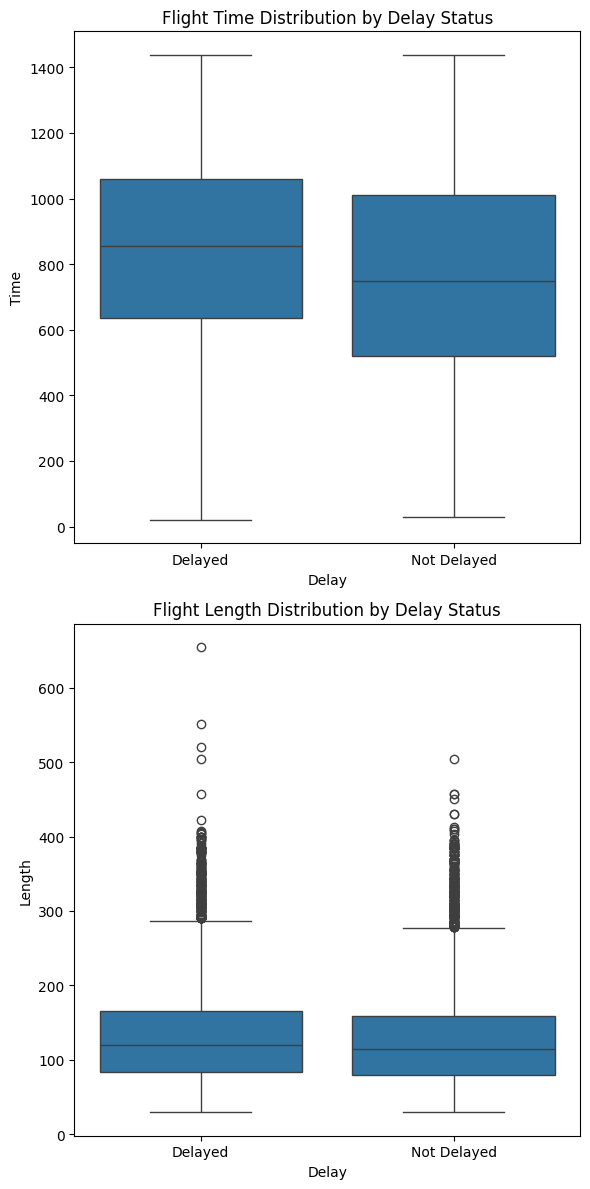

In [17]:
# Categorical Column
numerical_cols = ['Time', 'Length']

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(6, 12)) 
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Delay', y=col, ax=axes[i])
    axes[i].set_title(f"Flight {col} Distribution by Delay Status")

plt.savefig("../outputs/eda/delay_vs_categorical_col.png")
plt.tight_layout()
plt.show()

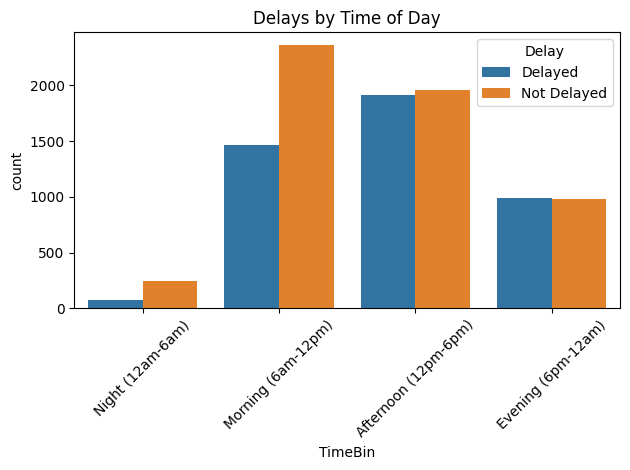

In [18]:
# Create time bins
timed_df = df.copy()
timed_df['TimeBin'] = pd.cut(df['Time'],
                       bins=[0, 360, 720, 1080, 1440],
                       labels=['Night (12am-6am)', 'Morning (6am-12pm)', 'Afternoon (12pm-6pm)', 'Evening (6pm-12am)'])

plt.figure()
sns.countplot(data=timed_df, x='TimeBin', hue='Delay')
plt.title('Delays by Time of Day')
plt.xticks(rotation=45)
plt.savefig("../outputs/eda/delay_vs_time.png")
plt.tight_layout()

### B. Correlation Heatmap

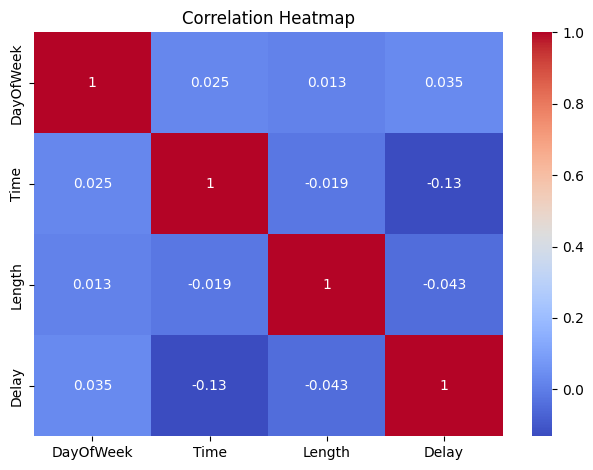

In [19]:
# Only numerical columns
num_df = df[['DayOfWeek', 'Time', 'Length']].copy()

# Add Delay as numeric for correlation
df['Delay'] = df['Delay'].astype('category')
num_df['Delay'] = df['Delay'].cat.codes

# Correlation
plt.figure()
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("../outputs/eda/correlation_heatmap.png")
plt.tight_layout()

## 4. Feature Extraction

In [20]:
# df['Delay'] = df['Delay'].cat.codes
from sklearn.preprocessing import LabelEncoder

for col in ['Airline', 'AirportFrom', 'AirportTo']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## 5. Train-Test split

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop('Delay', axis=1)
y = df['Delay'].map({'Not Delayed':0, 'Delayed':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 8)
Test shape: (2000, 8)


## 6.Model Building

In [25]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 7.Model Evaluation

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = xgb_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.6235

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.68      1110
           1       0.59      0.52      0.55       890

    accuracy                           0.62      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.62      0.62      2000


Confusion Matrix:
 [[782 328]
 [425 465]]


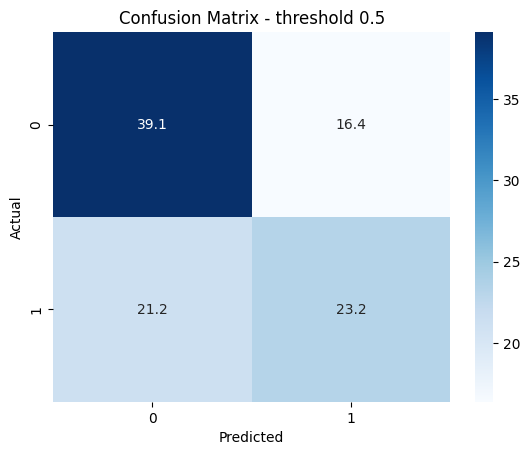

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.show()

## 8. Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(random_state=42)
param_grids = {'n_estimators': [100, 200],
              'max_depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.7, 0.8, 1.0],
              'colsample_bytree': [0.7, 0.8, 1.0]}

grid_search = GridSearchCV(estimator=xgb, 
                          param_grid=param_grids, 
                          cv = 3, 
                          scoring='accuracy', 
                          n_jobs=9, 
                          verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=9,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8], 'n_estimators': [100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [29]:
print("Best params :: \n", grid_search.best_params_, end ='\n\n')
print("Best Score  :: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model

Best params :: 
 {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

Best Score  ::  0.6419994106138084


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 9. Best Model

In [36]:
selected_model = best_model

### A. Default Threshold - 0.5

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = selected_model.predict(X_test)
y_prob = selected_model.predict_proba(X_test)[:, 1]

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.6315

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.89      0.73      1110
           1       0.69      0.31      0.43       890

    accuracy                           0.63      2000
   macro avg       0.65      0.60      0.58      2000
weighted avg       0.65      0.63      0.60      2000


Confusion Matrix:
 [[985 125]
 [612 278]]


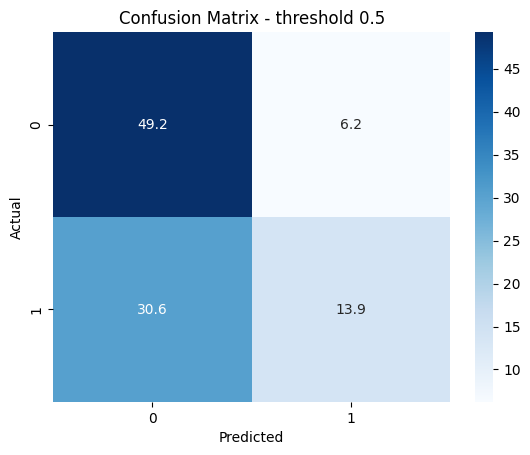

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.savefig("../outputs/results/default_threshold_cm.png")
plt.show()

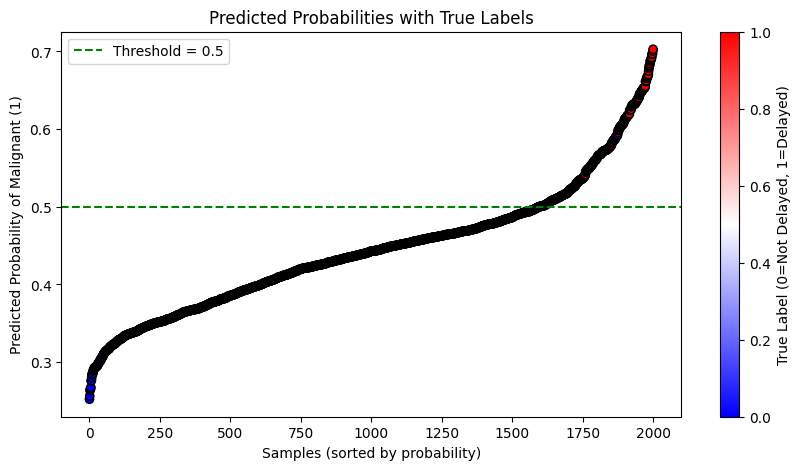

In [39]:
# Sort probabilities for better visualization
sorted_index = np.argsort(y_prob)
y_prob_sorted = y_prob[sorted_index]
y_test_sorted = y_test.values[sorted_index]  # if y_test is pandas Series

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_prob_sorted)), y_prob_sorted, 
            c=y_test_sorted, cmap='bwr', edgecolor='k')
plt.axhline(0.5, color='green', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Samples (sorted by probability)')
plt.ylabel('Predicted Probability of Malignant (1)')
plt.title('Predicted Probabilities with True Labels')
plt.legend()
plt.colorbar(label="True Label (0=Not Delayed, 1=Delayed)")
plt.savefig("../outputs/results/visual_representation.png")
plt.show()

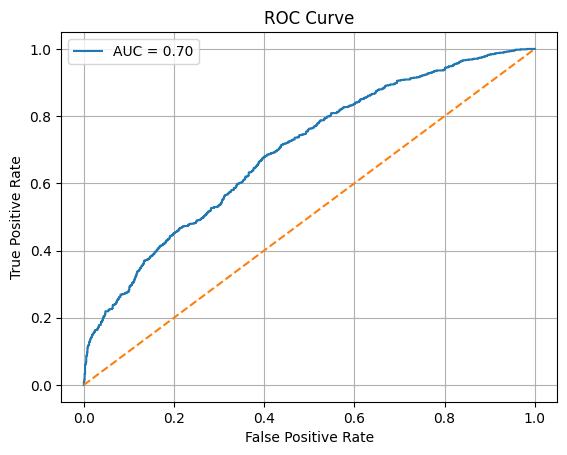

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("../outputs/results/roc_curve.png")
plt.show()

### B. Best Threshold

In [41]:
thresholds = np.arange(0, 1.01, 0.01)

best_threshold = 0.5
best_accuracy = 0

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = t

y_pred_t = (y_prob >= best_threshold).astype(int)

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 0.48
Best Accuracy: 0.6455


In [42]:
print(f"Accuracy :: {accuracy_score(y_test, y_pred_t)}")
print(f"\nClassification report :: \n", classification_report(y_test, y_pred_t))

Accuracy :: 0.6455

Classification report :: 
               precision    recall  f1-score   support

           0       0.64      0.83      0.72      1110
           1       0.66      0.41      0.51       890

    accuracy                           0.65      2000
   macro avg       0.65      0.62      0.62      2000
weighted avg       0.65      0.65      0.63      2000



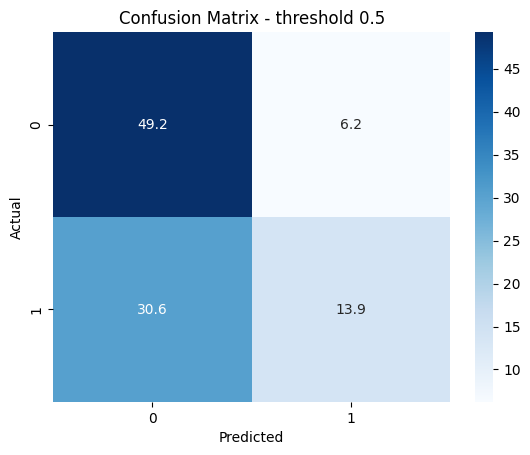

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.savefig("../outputs/results/best_threshold_cm.png")
plt.show()

## 10. Save and Load Model

In [44]:
import joblib

joblib.dump(selected_model, "../outputs/models/xgboost.pkl")
print("Model saved successfully!")

loaded_model = joblib.load("../outputs/models/xgboost.pkl")
y_pred_loaded = loaded_model.predict(X_test)

Model saved successfully!


## 11. Bagging(RandomForest) Vs Boosting(XGBoost)

In [24]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# --------------------------
# 1. Load Models
# --------------------------
rf_model = joblib.load("../outputs/models/randomForest.pkl")
xgb_model = joblib.load("../outputs/models/xgboost.pkl")

# --------------------------
# 3. Predictions
# --------------------------
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# For ROC-AUC we need probabilities
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# --------------------------
# 4. Evaluate Both Models
# --------------------------
metrics = {
    "Random Forest": [
        accuracy_score(y_test, rf_preds),
        f1_score(y_test, rf_preds),
        roc_auc_score(y_test, rf_probs)
    ],
    "XGBoost": [
        accuracy_score(y_test, xgb_preds),
        f1_score(y_test, xgb_preds),
        roc_auc_score(y_test, xgb_probs)
    ],
}

comparison_df = pd.DataFrame(metrics, index=["Accuracy", "F1 Score", "ROC-AUC"])
print(comparison_df)


          Random Forest   XGBoost
Accuracy       0.647500  0.631500
F1 Score       0.562926  0.430008
ROC-AUC        0.691531  0.695053
